In [1]:
import os
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
train_aug = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=25, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2, 
        zoom_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest")

val_aug = ImageDataGenerator(
        preprocessing_function=preprocess_input
)

In [3]:
train_path = '/kaggle/input/face-expression-recognition-dataset/images/train/'
train_data = train_aug.flow_from_directory(
            train_path,
            target_size = (48,48),
            shuffle = True)

Found 28821 images belonging to 7 classes.


In [4]:
val_path = '/kaggle/input/face-expression-recognition-dataset/images/validation/'
val_data = val_aug.flow_from_directory(
        val_path,
        target_size = (48,48),
        shuffle = True
        )

Found 7066 images belonging to 7 classes.


In [2]:
def create_cnn():
    model = Sequential([
        Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(48, 48, 3)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same"),
        
        MaxPool2D(2, 2),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        
        Conv2D(128, (3, 3), activation="relu", padding="same"),
        MaxPool2D(2, 2),
        
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPool2D(2, 2),
        Flatten(),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(7, activation='softmax')
    ])
    return model

In [12]:
checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/best_model_weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=5, min_lr=0.00000001)
history=model.fit(x_train, y_train, batch_size=16, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])

In [3]:
model = create_cnn()
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"])
model.summary()
# history = model.fit(train_data,epochs = 70,validation_data = val_data, callbacks = [checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0

In [9]:
model.save("/kaggle/working/best_cnn_model_69_accuracy.h5")

In [33]:
y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis = 1)

cm = confusion_matrix(val_data.classes, y_pred_classes)
labels = list(val_data.class_indices.keys())
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
display.plot()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()

# Specify the save path and filename
save_path = '/kaggle/working//confusion_matrix.png'
plt.savefig(save_path)
plt.close()

221/221 [==============================] - 7s 32ms/step


In [26]:
model = create_cnn()
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"])
model.fit(train_data,epochs = 50,validation_data = val_data, callbacks = [checkpoint_callback])

Epoch 1/50
901/901 [==============================] - ETA: 0s - loss: 1.8482 - accuracy: 0.2527
Epoch 1: val_accuracy improved from -inf to 0.33314, saving model to /kaggle/working/best_model_weights.h5
901/901 [==============================] - 190s 204ms/step - loss: 1.8482 - accuracy: 0.2527 - val_loss: 1.6736 - val_accuracy: 0.3331
Epoch 2/50
901/901 [==============================] - ETA: 0s - loss: 1.6728 - accuracy: 0.3277
Epoch 2: val_accuracy improved from 0.33314 to 0.41296, saving model to /kaggle/working/best_model_weights.h5
901/901 [==============================] - 66s 73ms/step - loss: 1.6728 - accuracy: 0.3277 - val_loss: 1.4814 - val_accuracy: 0.4130
Epoch 3/50
901/901 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.4228
Epoch 3: val_accuracy improved from 0.41296 to 0.48528, saving model to /kaggle/working/best_model_weights.h5
901/901 [==============================] - 69s 77ms/step - loss: 1.4846 - accuracy: 0.4228 - val_loss: 1.3383 - val_a

In [38]:
#Change shuffle = False when getting the scores

y_pred = model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = val_data.classes
report = classification_report(y_true, y_pred_classes, target_names=val_data.class_indices)
print(report)

221/221 [==============================] - 7s 30ms/step
              precision    recall  f1-score   support

       angry       0.64      0.54      0.59       960
     disgust       0.79      0.66      0.72       111
        fear       0.61      0.44      0.51      1018
       happy       0.87      0.89      0.88      1825
     neutral       0.56      0.77      0.65      1216
         sad       0.58      0.60      0.59      1139
    surprise       0.82      0.75      0.79       797

    accuracy                           0.69      7066
   macro avg       0.70      0.66      0.67      7066
weighted avg       0.69      0.69      0.69      7066



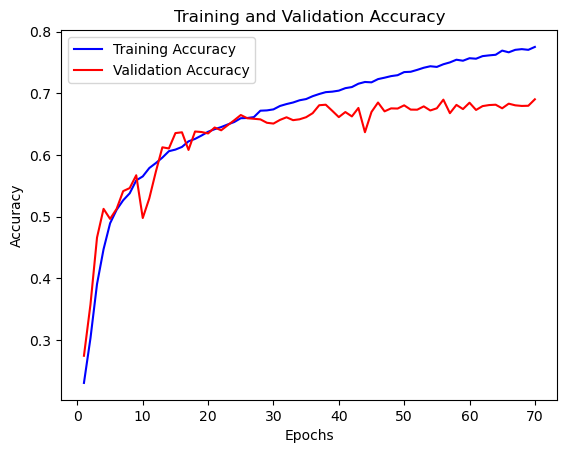

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy curve
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/kaggle/working/accuracy_cnn.png')

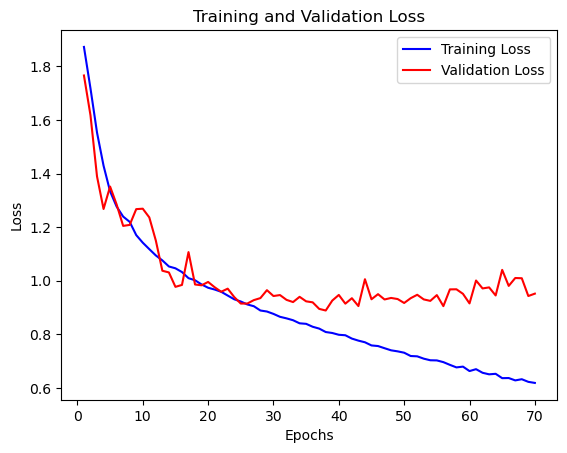

In [17]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/loss_cnn.png')

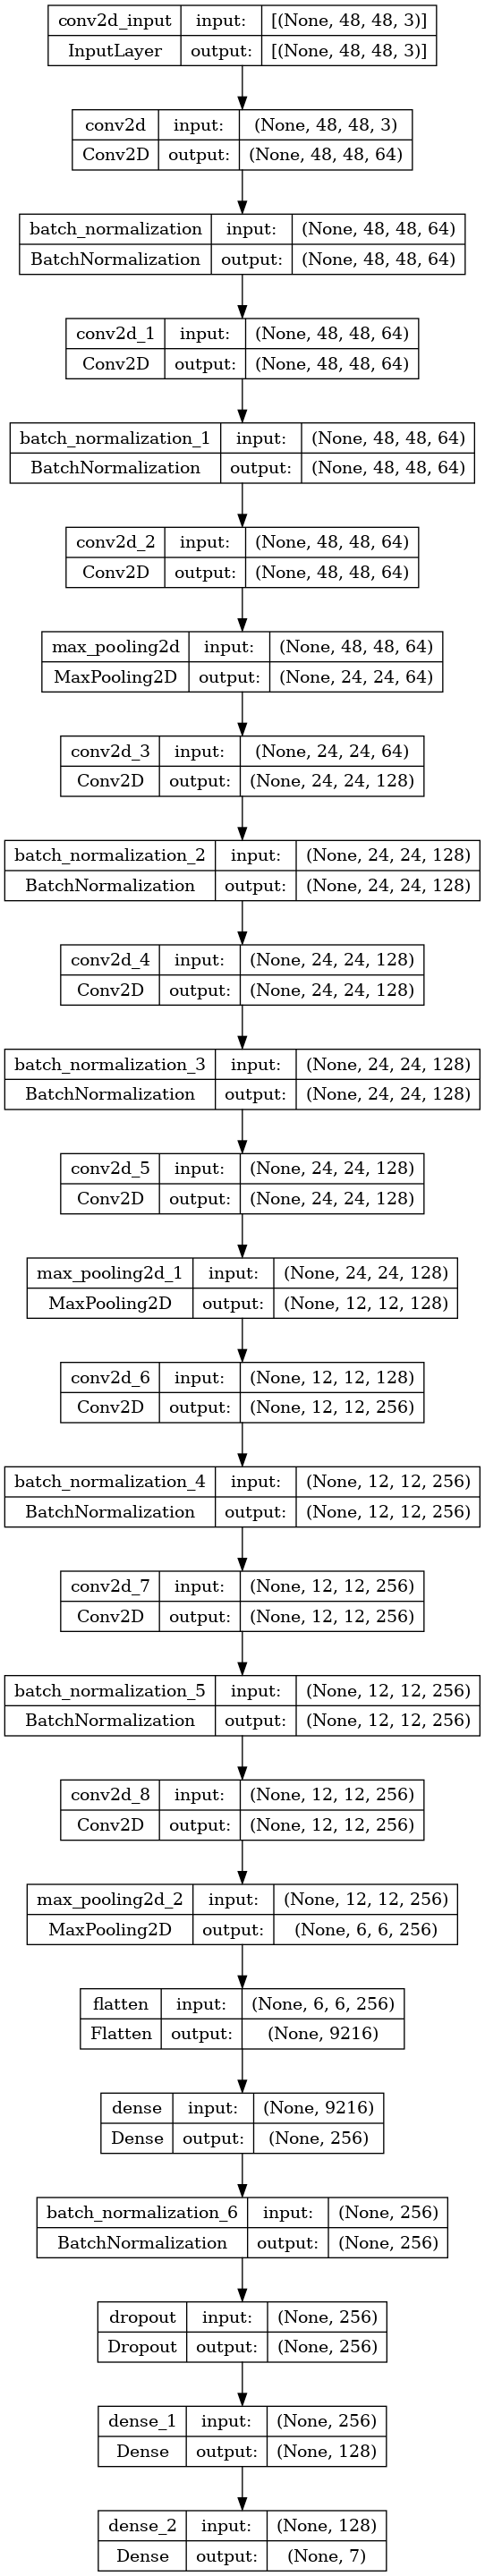

In [4]:
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True)

In [21]:
def get_label(i):
    return list(train_data.class_indices.keys())[i]

In [29]:
test_data = []
test_path = "/kaggle/input/face-expression-recognition-dataset/images/validation"

for folder in sorted(os.listdir(test_path)):
    image_folder =  test_path +"/"+ folder
    images = sorted(os.listdir(image_folder))
    for image in images:
        image_path = image_folder +"/"+ image
        x = Image.open(image_path)
        x = np.array(x.convert("RGB"))
        img_resize = cv2.resize(x, (224,224))
        test_data.append(img_resize)

Loaded the images of -angry having 960 images. 

Loaded the images of -disgust having 111 images. 

Loaded the images of -fear having 1018 images. 

Loaded the images of -happy having 1825 images. 

Loaded the images of -neutral having 1216 images. 

Loaded the images of -sad having 1139 images. 

Loaded the images of -surprise having 797 images. 



In [30]:
def get_wrong_classifications(true_label, predicted_label, save_path):
    rows, cols = 1, 5
    fig, ax = plt.subplots(rows, cols, figsize=(10, 3))
    x = ((y_pred_classes == predicted_label) & (val_data.classes == true_label))
    y = np.where(x == True)[0]
    z = np.random.randint(0, len(y), 5)
    fig.suptitle('Predicted: {}, Real: {}'.format(get_label(predicted_label), get_label(true_label)), fontsize=11)
    for col in range(cols):
        ax[col].imshow(test_data[y[z[col]]])
        ax[col].tick_params(
            axis='both',
            which='both',
            bottom=False,
            left=False,
            top=False,
            labelbottom=False,
            labelleft=False)

    plt.savefig(save_path)
    plt.close()

In [32]:
get_wrong_classifications(0,5, "/kaggle/working/error_1.png")
get_wrong_classifications(1,0, "/kaggle/working/error_2.png")
get_wrong_classifications(5,0, "/kaggle/working/error_3.png")
get_wrong_classifications(2,5, "/kaggle/working/error_4.png")
get_wrong_classifications(2,6, "/kaggle/working/error_5.png")